In [205]:
base_url = "..\\experiment(Jupyter)_artifacts\\"
dataset_folder_path = "built_dataset"
train_file_name = "train.csv"
feature_engineering_artifacts_folder = "Feature_Engineering"
TARGET_FEATURE = "Time_taken"
useless_features = ['ID', 'Delivery_person_ID']
MAX_UNIQUE_VALUES_FOR_DISCRETE_FEATURES = 25
validation_file = "validation.csv"

pipeline_file_name = 'pipeline.joblib'

# Loading Libraries

In [206]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from typing import List
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score

pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

# Creating the paths and folders

In [207]:
train_file_path = os.path.join(base_url,dataset_folder_path,train_file_name)

In [208]:
validation_file_path = os.path.join(base_url,dataset_folder_path,validation_file)

In [209]:
pipeline_file_path = os.path.join(base_url,pipeline_file_name)

# Preprocess Classes

In [329]:
class DropUndersiredFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=['ID', 'Delivery_person_ID']):
        
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self  # nothing to do

    def transform(self, X, y=None):
        df = X.copy()
        for feature in self.features_to_drop:
            ## try and catch to avoid run time errors
            try:
                df.drop(feature, axis=1, inplace=True)
            except:
                pass

        return df

## Imputing Numerical features class

class ImputeNumericalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numerical_features_nan = []
        self.medians = []
        
    def fit(self,X,y=None):
        try:
            ### Numerical features having null features
            
            self.numerical_features_nan = [feature for feature in X.columns if X[feature].dtypes !='O' and X[feature].isnull().sum()>=1]
        
            self.medians = []
            for feature in self.numerical_features_nan:
                self.medians.append(X[feature].median())
        except:
            pass
        
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        for index, feature in enumerate(self.numerical_features_nan):

            try:
                median_value = self.medians[index]
                ## create new feature to capture nan values
                df[feature + '_nan'] = np.where(df[feature].isnull(), 1, 0)
                ### replace the missing values with median
                df[feature] = df[feature].fillna(median_value)

            except:
                pass
        return df
        
class ImputeCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_features = []  # empty categorical features list

    def fit(self, X, y=None):
        try:
            # Get the categorical features
            self.categorical_features = [feature for feature in X.columns if X[feature].dtype == 'O']
        except:
            pass

        return self

    def transform(self, X, y=None):
        ## standardize the features
        df = X.copy()
        try:
            for feature in self.categorical_features:
                df[feature] = df[feature].str.lower()
        except:
            pass

        ## Handle missing values
        try:
            df[self.categorical_features] = df[self.categorical_features].fillna('missing')

        except:
            pass

        return df
class ExtractFromTemporalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, temporal_features = ['Order_Date', 'Time_Order_picked', 'Time_Orderd']):
        
        self.temporal_features = temporal_features
    
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X, y = None):
        df = X.copy()
        
        try:
            ## Working on Order Date
            df[self.temporal_features[0]+"_Day"] = df[self.temporal_features[0]].str.split('-').str[0].astype(int)
            df[self.temporal_features[0]+"_Month"] = df[self.temporal_features[0]].str.split('-').str[1].astype(int)
            
            
            
            ### Working on Time Order Picked
            df[self.temporal_features[1]+"_Hr"] = df[self.temporal_features[1]].str.split(':').str[0].astype(int)
            df[self.temporal_features[1]+"_Min"] = df[self.temporal_features[1]].str.split(':').str[1].astype(int)
            
            df.drop(self.temporal_features, axis = 1, inplace = True)
            
            return df
        except Exception as e:
            print(str(e))
        
        
class GenerateDistanceFromLatitudeAndLongitude(BaseEstimator,TransformerMixin):
    def __init__(self,distance_features = ['Restaurant_latitude', 'Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']):
        self.distance_features = distance_features
    
    def fit(self,X,y=None):
        #print('fit')
        return self
    
    def transform(self,X,y=None):
        df = X.copy()
        #print('transform')
        try:
            ## Convert features to radians
            for feature in self.distance_features:
                df[feature] = np.radians(df[feature])
                
            lat1 = df[self.distance_features[0]]
            lon1 = df[self.distance_features[1]]
            
            lat2 = df[self.distance_features[2]]
            lon2 = df[self.distance_features[3]]
            
            
            newlon = lon2 - lon1
            newlat = lat2 - lat1
            
            haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
            
            dist = 2 * np.arcsin(np.sqrt(haver_formula ))
            
            km = 6367 * dist #6367 for distance in KM for miles use 3958

            df['Distance'] = km
            
            
            
            return df
         
        except Exception as e:
            print(str(e))
        
        
class Label_Encode(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_features = ['Festival','Road_traffic_density']):
        self.ordinal_features = ordinal_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        try:
            #print(df[self.ordinal_features])
            df['Festival'] = df['Festival'].map({'no':0,'yes':1,'missing':0})
            df['Road_traffic_density']=df['Road_traffic_density'].map({'low':0,'medium' : 1,'high' : 2,'jam':3,'missing' : 0})
            
            
            return df
        except:
            print(str(e))

class OHE_Categorical_Features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_features = []
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    def fit(self, X, y=None):
        try:
            self.categorical_features = [feature for feature in X.columns if X[feature].dtype == 'O']
            self.ohe.fit(X[self.categorical_features])
            ##print(self.ohe.categories_)
        except:
            pass

        return self

    def transform(self, X, y=None):
        df = X.copy()
        try:
            cat_ohe = self.ohe.transform(df[self.categorical_features])

            ohe_df = pd.DataFrame(cat_ohe, columns=self.ohe.get_feature_names(input_features=self.categorical_features),
                                  index=df.index)
            df = pd.concat([df, ohe_df], axis=1).drop(columns=self.categorical_features, axis=1)
        except Exception as e:
            pass

        return df


class remove_high_corelated_features(BaseEstimator, TransformerMixin):
    @staticmethod
    ## We set a corelation threshold (probably 0.85)
    ## We iterate on corelation matrix and see if 2 features have this much or greater corelation.
    ## If they have, we will remove one of the features.

    def get_high_correlation_feature(dataset, threshold):
        col_corr = set() ## set of column names to be dropped
        corr_matrix = dataset.corr()

        for i in range(len(corr_matrix.columns)-1,-1,-1):
            for j in range(i-1,-1,-1):
                if abs(corr_matrix.iloc[i,j]) > threshold:
                    colname = corr_matrix.columns[i] ## getting the column name
                    #print(corr_matrix.columns[i],"-----" ,corr_matrix.columns[j], "====", corr_matrix.iloc[i,j])
                    col_corr.add(colname)
        return(col_corr)
            
    
    def __init__(self, threshold = 0.85):
        self.correlated_features = []
        self.threshold = threshold
    
    def fit(self,X,y=None):
        self.correlated_features= remove_high_corelated_features.get_high_correlation_feature(X,self.threshold)
        
        return self
        
    def transform(self,X,y=None):
        df = X.copy()
        
        for feature in self.correlated_features:
            try:
                df.drop(feature,axis = 1, inplace= True)
            except:
                continue
        return df

# Loading the data and pipeline

In [330]:
train_df = pd.read_csv(train_file_path)

In [331]:
validation_df = pd.read_csv(validation_file_path)

In [332]:
pipeline = joblib.load(pipeline_file_path)

# Seperating independant and dependant features

In [333]:
X_train,y_train = train_df.drop(TARGET_FEATURE, axis = 1), train_df[TARGET_FEATURE]

In [334]:
X_validation , y_validation = validation_df.drop(TARGET_FEATURE, axis = 1), validation_df[TARGET_FEATURE]

In [335]:
pipeline.fit(X_train)

C:\Users\rachi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Pipeline(steps=[('drop_undesired_features', DropUndersiredFeatures()),
                ('impute_numerical_features', ImputeNumericalFeatures()),
                ('impute_categorical_features', ImputeCategoricalFeatures()),
                ('label_encode', Label_Encode()),
                ('extract_temporal_features', ExtractFromTemporalFeatures()),
                ('generate_distance',
                 GenerateDistanceFromLatitudeAndLongitude()),
                ('OHE', OHE_Categorical_Features()),
                ('remove_correlated_features',
                 remove_high_corelated_features()),
                ('scaler', StandardScaler())])

In [336]:
X_train_transformed = pipeline.transform(X_train)

C:\Users\rachi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [337]:
X_validation_transformed = pipeline.transform(X_validation)

C:\Users\rachi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Linear Regression

In [338]:
from sklearn.linear_model import LinearRegression

In [339]:
lr = LinearRegression()

In [340]:
lr.fit(X_train_transformed,y_train)

LinearRegression()

In [341]:
predictions_train = lr.predict(X_train_transformed)

In [342]:
predictions_validation = lr.predict(X_validation_transformed)

In [343]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))

In [344]:
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [345]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			6.283750450974074			0.5514080122160898
Validation		6.258261920952541			0.5558624520261746


# SVR

In [346]:
from sklearn.svm import LinearSVR

In [347]:
svr = LinearSVR()

In [348]:
svr.fit(X_train_transformed,y_train)

LinearSVR()

In [349]:
predictions_train = svr.predict(X_train_transformed)

In [350]:
predictions_validation = svr.predict(X_validation_transformed)

In [351]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))

In [352]:
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [353]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			6.3057613254215354			0.5482598301643862
Validation		6.285776331504769			0.551948571152814


# Random Forests

In [354]:
from sklearn.ensemble import RandomForestRegressor

In [355]:
rf  =RandomForestRegressor()

In [356]:
rf.fit(X_train_transformed,y_train)

RandomForestRegressor()

In [357]:
predictions_train = rf.predict(X_train_transformed)

In [358]:
predictions_validation = rf.predict(X_validation_transformed)

In [359]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [360]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			1.4965263273387646			0.9745561763628854
Validation		3.9987288376607935			0.8186765685092584


# Extra Trees

In [361]:
from sklearn.ensemble import ExtraTreesRegressor

In [362]:
extra = ExtraTreesRegressor()

In [363]:
extra.fit(X_train_transformed,y_train)

ExtraTreesRegressor()

In [364]:
predictions_train = extra.predict(X_train_transformed)
predictions_validation = extra.predict(X_validation_transformed)

In [365]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [366]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			0.0			1.0
Validation		4.12921051031973			0.8066500481871651


# Ada Boost

In [367]:
from sklearn.ensemble import AdaBoostRegressor

In [368]:
ada = AdaBoostRegressor()

In [369]:
ada.fit(X_train_transformed,y_train)

AdaBoostRegressor()

In [370]:
predictions_train = ada.predict(X_train_transformed)
predictions_validation = ada.predict(X_validation_transformed)

In [371]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [372]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			5.907214977180036			0.6035584130871864
Validation		5.937072374535036			0.6002810791753375


# Gradient Boosting

In [373]:
from sklearn.ensemble import GradientBoostingRegressor

In [374]:
gb = GradientBoostingRegressor()

In [375]:
gb.fit(X_train_transformed,y_train)

GradientBoostingRegressor()

In [376]:
predictions_train = gb.predict(X_train_transformed)
predictions_validation = gb.predict(X_validation_transformed)

In [377]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [378]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			4.519684280679446			0.7679242029233958
Validation		4.60143936053019			0.7598970886042629


# XGBoost

In [379]:
from xgboost import XGBRegressor, XGBRFRegressor

In [380]:
xgb = XGBRegressor()

In [381]:
xgb.fit(X_train_transformed,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [382]:
predictions_train = xgb.predict(X_train_transformed)
predictions_validation = xgb.predict(X_validation_transformed)

In [383]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [384]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			3.4057336618134535			0.8682243954225751
Validation		4.031663388675216			0.8156774161755234


#### XGBRF

In [385]:
xgbrf = XGBRFRegressor()

In [386]:
xgbrf.fit(X_train_transformed,y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='', max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_state=0,
               reg_alpha=0, sampling_method='uniform', scale_pos_weight=1, ...)

In [387]:
predictions_train = xgbrf.predict(X_train_transformed)
predictions_validation = xgbrf.predict(X_validation_transformed)

In [388]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [389]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			5.292806214872621			0.681737374883209
Validation		5.413638362062779			0.6676554954611611


# Random Forest Looks the most promising

In [622]:
rf = RandomForestRegressor(n_estimators=200, min_samples_split= 6,max_depth=15)

In [623]:
#rf = RandomForestRegressor(n_estimators=100, min_samples_split= 6,max_depth=15, criterion='absolute_error',verbose=10, n_jobs=-1)

In [624]:
rf.fit(X_train_transformed,y_train)

RandomForestRegressor(max_depth=15, min_samples_split=6, n_estimators=200)

In [625]:
predictions_train = rf.predict(X_train_transformed)
predictions_validation = rf.predict(X_validation_transformed)

In [626]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [627]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			2.8922207206433685			0.9049665446833858
Validation		3.9340134299299283			0.8244981510054044


# Clustering

In [396]:
from sklearn.cluster import KMeans

In [397]:
kmeans = KMeans()

In [398]:
kmeans.fit(X_train_transformed)

KMeans()

In [408]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
silhouette_score

For no of clusters : 2 , sil score is 0.08620890323011635
For no of clusters : 3 , sil score is 0.08556259484378309
For no of clusters : 4 , sil score is 0.07295097443999105
For no of clusters : 5 , sil score is 0.05525393709258823
For no of clusters : 6 , sil score is 0.07228909236777527
For no of clusters : 7 , sil score is 0.13797034395665403
For no of clusters : 8 , sil score is 0.14210287526157056
For no of clusters : 9 , sil score is 0.11503799925015289
For no of clusters : 10 , sil score is 0.15010072078457487
For no of clusters : 11 , sil score is 0.11129549832118608
For no of clusters : 12 , sil score is 0.11709915319787222
For no of clusters : 13 , sil score is 0.10533210416339435
For no of clusters : 14 , sil score is 0.1159597828574596
For no of clusters : 15 , sil score is 0.11917876613723252
For no of clusters : 16 , sil score is 0.12193256744926137
For no of clusters : 17 , sil score is 0.12589442999475725
For no of clusters : 18 , sil score is 0.1251907717336576
For no 

ValueError: x and y must have same first dimension, but have shapes (69,) and (68,)

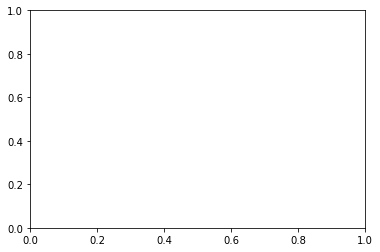

In [419]:
"""
wcss=[]
for i in range(2,70):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(X_train_transformed)
    labels = kmeans.predict(X_train_transformed)
    
    print(f"For no of clusters : {i} , sil score is {silhouette_score(X_train_transformed,labels)}")
    
    wcss.append(kmeans.inertia_)
"""

plt.plot(range(2,70),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

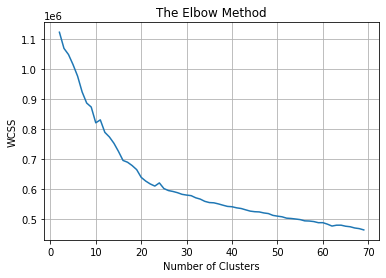

In [422]:
plt.plot(range(2,70),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [537]:
kmeans=KMeans(n_clusters=10, init='k-means++',random_state=0)
kmeans.fit(X_train_transformed)



KMeans(n_clusters=10, random_state=0)

### Let's check for 1 cluster

In [541]:
train_labels = kmeans.predict(X_train_transformed)
train_indices = np.where(train_labels == 5)

In [542]:
cluster_X_train_transformed = X_train_transformed[train_indices]

In [543]:
train_indices[0].shape

(5770,)

In [544]:
cluster_y_train_transformed = np.array(y_train)[train_indices]


In [545]:
validation_labels = kmeans.predict(X_validation_transformed)

In [546]:
validation_indices = np.where(validation_labels == 0)

In [547]:
cluster_X_validation_transformed = X_validation_transformed[validation_indices]
cluster_y_validation_transformed = np.array(y_validation)[validation_indices]

In [569]:
rf = RandomForestRegressor(n_estimators=500,min_samples_split=6)


In [570]:
rf.fit(cluster_X_train_transformed,cluster_y_train_transformed)

RandomForestRegressor(min_samples_split=6, n_estimators=500)

In [571]:
predictions_train = rf.predict(cluster_X_train_transformed)
predictions_validation = rf.predict(cluster_X_validation_transformed)

In [572]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(cluster_y_train_transformed,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(cluster_y_validation_transformed,predictions_validation))
r2_train = r2_score(cluster_y_train_transformed,predictions_train)
r2_validation = r2_score(cluster_y_validation_transformed,predictions_validation)

In [573]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			1.9915803398517604			0.946170445230509
Validation		4.163950501003014			0.7589657922471997


# Hyperparameter Tuning

In [594]:
parameters = {
    "n_estimators":[50,100,200,500,1000],
    
    'min_samples_split':[2,4,6],
    'max_features':['int','sqrt','log2'],
    'bootstrap':[True,False],
}

In [595]:
from sklearn.model_selection import GridSearchCV


In [596]:
rf= RandomForestRegressor()

In [597]:
grid = GridSearchCV(rf, parameters,cv=3,verbose=10,n_jobs=-1, scoring='r2')

In [598]:
grid.fit(X_train_transformed,y_train)


Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\rachi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rachi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rachi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\rachi\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\rachi\anaconda3\lib\site-packages\j

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['int', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             scoring='r2', verbose=10)

In [599]:
grid.best_score_

0.8190368552299767

In [600]:
grid.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_split': 6,
 'n_estimators': 1000}

In [602]:
best_model = grid.estimator

In [604]:
best_model.fit(X_train_transformed,y_train)

RandomForestRegressor()

In [605]:
predictions_train = best_model.predict(X_train_transformed)
predictions_validation = best_model.predict(X_validation_transformed)

In [608]:
root_mean_squared_error_train = np.sqrt(mean_squared_error(y_train,predictions_train))
root_mean_squared_error_validation = np.sqrt(mean_squared_error(y_validation,predictions_validation))
r2_train = r2_score(y_train,predictions_train)
r2_validation = r2_score(y_validation,predictions_validation)

In [609]:
print("Dataset\t\t\tRoot mean square error\t\t\tR square score")
print(f"Train\t\t\t{root_mean_squared_error_train}\t\t\t{r2_train}")
print(f"Validation\t\t{root_mean_squared_error_validation}\t\t\t{r2_validation}")

Dataset			Root mean square error			R square score
Train			1.49830656177282			0.9744956055440702
Validation		4.008381107501108			0.8178001424818957
